In [1]:
import holoviews as hv
import holoviews.util
#hv.extension('bokeh')
from matplotlib import colors
hv.extension('matplotlib')
%output fig='pdf'

import numpy as np
import cPickle
import yt
import matplotlib.pyplot as pl
from astropy.cosmology import WMAP9 as cosmo
from astropy.table import Table
from emission_functions import *
import pandas as pd
import datashader as dshade
import matplotlib.pyplot as plt

from holoviews.operation.datashader import aggregate, datashade, dynspread, shade
from holoviews.operation import decimate
from holoviews.operation import histogram
from holoviews import Store

/Users/dalek/anaconda2/lib/python2.7/site-packages/yt/fields/local_fields.py:46: UserWarning: Because 'sampling_type' not specified, yt will assume a cell 'sampling_type'
  warnings.warn("Because 'sampling_type' not specified, yt will "


In [2]:
def make_radius_array(rb_width,frbarr):
    box_size = rb_width/2.
    num_cells = frbarr.shape[0]
    xL = np.linspace(-1*box_size,box_size,num_cells)
    xL2,yL = np.meshgrid(xL,xL)
    r = abs(xL2+1j*yL)
    return r 

## Perfecting Radial Profiles with Holoviews + Datashader

In [3]:
base = "/Users/dalek/data/Molly/nref11n_nref10f_refine200kpc_z4to2"
fn = base+"/RD0020/RD0020"
lines = ['HAlpha','OVI','CIV','CIII_977','SiIV']
track_name = base+"/halo_track"
args = fn.split('/')

ds = yt.load(fn)
track = Table.read(track_name, format='ascii')
track.sort('col1')
rb,rb_center,rb_width = get_refine_box(ds,ds.current_redshift,track)
redshift = ds.current_redshift

box_width = ds.arr(rb_width,'code_length').in_units('kpc')

yt : [INFO     ] 2018-02-15 16:15:12,996 Parameters: current_time              = 154.801032717
yt : [INFO     ] 2018-02-15 16:15:12,997 Parameters: domain_dimensions         = [256 256 256]
yt : [INFO     ] 2018-02-15 16:15:12,998 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2018-02-15 16:15:12,999 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2018-02-15 16:15:13,000 Parameters: cosmological_simulation   = 1
yt : [INFO     ] 2018-02-15 16:15:13,001 Parameters: current_redshift          = 1.99999968795
yt : [INFO     ] 2018-02-15 16:15:13,002 Parameters: omega_lambda              = 0.715
yt : [INFO     ] 2018-02-15 16:15:13,003 Parameters: omega_matter              = 0.285
yt : [INFO     ] 2018-02-15 16:15:13,004 Parameters: hubble_constant           = 0.695


using this loc:      col1       col2     col3     col4     col5     col6     col7   col8
------------- -------- -------- -------- -------- -------- -------- ----
2.04999996364 0.493091 0.488119 0.501099 0.495091 0.490119 0.503099   10


In [ ]:
natural_base = '_nref11_RD0020_'
refined_base = '_nref11n_nref10f_refine200kpc_z4to2_RD0020_'
box_size = ds.arr(rb_width,'code_length').in_units('kpc')
res_list = [0.2,1,5,10]
lines = ['CIII_977','OVI']

In [ ]:
field = 'Emission_CIII_977'
fileinNAT = 'frbs/frb'+'x'+natural_base+field+'_forcedres.cpkl'
fileinREF = 'frbs/frb'+'x'+refined_base+field+'_forcedres.cpkl'

frbNAT = cPickle.load(open(fileinNAT,'rb'))
frbREF = cPickle.load(open(fileinREF,'rb'))

frbNAT = np.log10(frbNAT/(1.+redshift)**4)
frbREF = np.log10(frbREF/(1.+redshift)**4)

r = make_radius_array(box_width,frbNAT)

In [ ]:
emisREF = frbREF.flatten()
dist = r.flatten()
detect_prob = np.chararray(np.size(dist), 4)
detect_prob[emisREF >= 3] = 'definite'
detect_prob[((emisREF < 3) & (emisREF >= 2))] = 'probable'
detect_prob[((emisREF < 2) & (emisREF >= 1))] = 'possible'
detect_prob[emisREF < 1] = 'nope'
dfREF = pd.DataFrame({'dist':dist,'emisREF':emisREF,'detect_prob':detect_prob})
dfREF.detec_prob = dfREF.detect_prob.astype('category') 

#arrH = np.zeros((len(idH),2))
#arrH[:,0],arrH[:,1] = dist[idH],emisREF[idH]
#arrM = np.zeros((len(idM),2))
#arrM[:,0],arrM[:,1] = dist[idM],emisREF[idM]
#arrL = np.zeros((len(idL),2))
#arrL[:,0],arrL[:,1] = dist[idL],emisREF[idL]
#arrN = np.zeros((len(idN),2))
#arrN[:,0],arrN[:,1] = dist[idN],emisREF[idN]

In [ ]:
print np.unique(dfREF['detect_prob'])

In [ ]:
dtest = dist[0:1000]
etest = emisREF[0:1000]
dfTEST = pd.DataFrame({'dist':dtest,'emisREF':etest})

In [ ]:
detect_color_key = {b'nope':'#808080',
                    b'poss':'#FF69B4',
                    b'prob':'#00CED1',
                    b'defi': '#32CD32'} #'#7FFF00'}

In [ ]:
#%%opts RGB [width=820] {+axiswise}

sb_point = hv.Points(dfREF,kdims=['dist','emisREF'],label='CIII 977') 
sb_shade = datashade(sb_point,color_key=detect_color_key,
                     aggregator=dshade.count_cat('detect_prob'),y_range=(-10,6),
                     dynamic=False).opts(plot=dict(aspect='square'))
sb_shade
#help(testout)

In [ ]:
from holoviews import Store
renderer = Store.renderers['matplotlib'].instance(fig='pdf', holomap='gif')
renderer.save(sb_shade, 'SBprof_test') 

In [ ]:
emisNAT = frbNAT.flatten()
dist = r.flatten()
detect_prob = np.chararray(np.size(dist), 4)
detect_prob[emisNAT >= 3] = 'definite'
detect_prob[((emisNAT < 3) & (emisNAT >= 2))] = 'probable'
detect_prob[((emisNAT < 2) & (emisNAT >= 1))] = 'possible'
detect_prob[emisNAT < 1] = 'nope'
dfNAT = pd.DataFrame({'dist':dist,'emisREF':emisNAT,'detect_prob':detect_prob})
dfNAT.detec_prob = dfNAT.detect_prob.astype('category') 

In [ ]:
test_plot = hv.Points(dfNAT,kdims=['dist','emisREF'],label='CIII 977') 
shade2 = datashade(test_plot,color_key=detect_color_key,
                   aggregator=dshade.count_cat('detect_prob'),y_range=(-10,6),
                   dynamic=False).opts(plot=dict(aspect='square',show_title=False))

test2 = (sb_shade+shade2).cols(1)
test3 = (sb_shade + sb_shade)
test4 = (shade2 + shade2)

(test3 + test4).cols(2)

In [ ]:
idH,idM,idL,idN = (emisREF >=3),((emisREF >=2) & (emisREF <3)), ((emisREF >=1) & (emisREF <2)),(emisREF <1)
eH,dH = emisREF[idH],dist[idH]
eM,dM = emisREF[idM],dist[idM]
eL,dL = emisREF[idL],dist[idL]
eN,dN = emisREF[idN],dist[idN]

ptsH = np.vstack((dH, eH)).T
ptsM = np.vstack((dM, eM)).T
ptsL = np.vstack((dL, eL)).T
ptsN = np.vstack((dN, eN)).T

In [ ]:
test_plot = hv.Points(ptsH,kdims=['dist','emisREF'],label='CIII 977').opts(style=dict(color=detect_color_key['defi']))
test_plot = test_plot * hv.Points(ptsM,kdims=['dist','emisREF'],
                                  label='CIII 977').opts(style=dict(color=detect_color_key['prob']))
test_plot = test_plot * hv.Points(ptsL,kdims=['dist','emisREF'],
                                  label='CIII 977').opts(style=dict(color=detect_color_key['poss']))
test_plot = test_plot * hv.Points(ptsN,kdims=['dist','emisREF'],
                                  label='CIII 977').opts(style=dict(color=detect_color_key['nope']))

In [ ]:
test_plot

## Connecting Emission and HI Properties

#### First, let's test out matching pixels from one frb to another. 

In [ ]:
cmap = colors.ListedColormap(['Gray','HotPink','DarkTurquoise','Chartreuse'])
bounds = [-5,1,2,3,5]
norm = colors.BoundaryNorm(bounds,cmap.N)

In [ ]:
data = cPickle.load(open('frbs/frbx_nref11_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emis = emis/(3.**4)
test = np.ma.masked_where((np.log10(emis) > 1.),emis)

In [ ]:
fig,ax = plt.subplots(1,2)

ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='Greys_r',vmin=12,vmax=23)
ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
plt.show()

In [ ]:
data = cPickle.load(open('frbs/frbx_nref11_RD0020_H_p0_number_density_10kpc.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_CIII_977_10kpc.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_OVI_forcedres.cpkl','rb'))
test = np.ma.masked_where((np.log10(emis) > 2.),emis)

fig,ax = plt.subplots(1,2)

ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='bone',vmin=12,vmax=23)
ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
plt.show()

Well now that I'm seeing these next to each other, I like them a lot less than I thought I would. Maybe if I try with the forced refinement it'll make more of an impact for me?

Ehh I'm still not really sure if these are necessary. Can show Molly and Jason though. At any rate, they could be interesting for a talk if not the paper.

In [ ]:
data = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emis = emis/(3.**4)
test = np.ma.masked_where((np.log10(emis) > 1.),emis)

fig,ax = plt.subplots(1,2)

out1 = ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
#plt.colorbar(out1)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='Greys_r',vmin=12,vmax=23)
out2 = ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
#plt.colorbar(out2)
plt.show()

In [ ]:
data = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_H_p0_number_density_10kpc.cpkl','rb'))
emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_CIII_977_10kpc.cpkl','rb'))
#emis = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_OVI_10kpc.cpkl','rb'))
emis = emis/(3.**4)
test = np.ma.masked_where((np.log10(emis) > 1.),emis)

fig,ax = plt.subplots(1,2)

ax[0].imshow(np.log10(emis),cmap=cmap,norm=norm,vmin=-6,vmax=6)
datamasked = data*test.mask
ax[1].imshow(np.log10(data),cmap='Greys_r',vmin=12,vmax=23)
ax[1].imshow(np.log10(datamasked),vmin=16,vmax=22,cmap='GnBu_r')
plt.show()

In [ ]:
colHI = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
emisCIII = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
emisOVI = cPickle.load(open('frbs/frbx_nref11n_nref10f_refine200kpc_z4to2_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emisCIII = np.log10(emisCIII/(3.**4))
emisOVI = np.log10(emisOVI/(3.**4))
colHI = np.log10(colHI)

iOVI = np.where(emisOVI >= 1.)
ptshereOVI = np.vstack((colHI[iOVI], emisOVI[iOVI])).T
iCIII = np.where(emisCIII >= 1.)
ptshereCIII = np.vstack((colHI[iCIII], emisCIII[iCIII])).T

pltOVI = hv.Points(ptshereOVI,kdims=['HI column','Emission'])#.opts(style=dict(alpha=0.4))
pltCIII = hv.Points(ptshereCIII,kdims=['HI column','Emission'])

datashade(pltCIII).opts(plot=dict(aspect='square')) + pltCIII

One thing that I could try to do is draw the contours, figure out ow to get them returned and then do a hybrid plot of shading within the contour and plotting the points that lie outside it.

In [ ]:
counts,ybins,xbins,image = plt.hist2d(colHI[iCIII],emisCIII[iCIII],bins=100,cmap='Blues')
tout = plt.contour(counts.T,extent=[ybins.min(),ybins.max(),xbins.min(),xbins.max()],linewidths=3,cmap='Reds_r')
#plt.contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3,color='red')

plt.show()

Buttt turns out getting those contours from matplotlib is so not easy. But in making emission pots for Jason, I refound code from my paper with David where I just used 2D histograms. If I pick a colorbar that doesn't end in white, even the low density points are shown.

In [ ]:
#colHI,emisOVI,emisCIII = colHI.flat,emisOVI.flat,emisCIII.flat
iOVI = np.where(emisOVI >= 1.)
colHIw,emisOVIw = colHI[iOVI],emisOVI[iOVI]
iCIII = np.where(emisCIII >= 1.)
colHIx,emisCIIIx = colHI[iCIII],emisCIII[iCIII]

hist, xedges, yedges  = np.histogram2d(colHIw,emisOVIw,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
print np.min(colHIx),np.max(colHI)
print np.min(emisCIIIx),np.max(emisCIIIx)

In [ ]:
hist, xedges, yedges  = np.histogram2d(colHIx,emisCIIIx,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
colHIN = cPickle.load(open('frbs/frbx_nref11_RD0020_H_p0_number_density_forcedres.cpkl','rb'))
emisCIIIN = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_CIII_977_forcedres.cpkl','rb'))
emisOVIN = cPickle.load(open('frbs/frbx_nref11_RD0020_Emission_OVI_forcedres.cpkl','rb'))
emisCIIIN = np.log10(emisCIIIN/(3.**4))
emisOVIN = np.log10(emisOVIN/(3.**4))
colHIN = np.log10(colHIN)

colHIN,emisOVIN,emisCIIIN = colHIN.flat,emisOVIN.flat,emisCIIIN.flat
iOVIN = np.where(emisOVIN >= 1.)
colHIwN,emisOVIwN = colHIN[iOVIN],emisOVIN[iOVIN]
iCIIIN = np.where(emisCIIIN >= 1.)
colHIxN,emisCIIIxN = colHIN[iCIIIN],emisCIIIN[iCIIIN]

In [ ]:
hist, xedges, yedges  = np.histogram2d(colHIwN,emisOVIwN,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
hist, xedges, yedges  = np.histogram2d(colHIxN,emisCIIIxN,bins=80,
                                       range=[[14,24],[0.5,7]])
plt.imshow(np.log10(hist.T),extent=[14,24,0.5,7],origin='lower')
plt.colorbar()
plt.show()

In [ ]:
ptshereOVIN = np.vstack((colHIN[iOVIN], emisOVIN[iOVIN])).T
ptshereCIIIN = np.vstack((colHIN[iCIIIN], emisCIIIN[iCIIIN])).T

pltOVIN = hv.Points(ptshereOVIN,kdims=['HI column','Emission'])#.opts(style=dict(alpha=0.4))
pltCIIIN = hv.Points(ptshereCIIIN,kdims=['HI column','Emission'])



In [ ]:
totalCIII = datashade(pltCIII).opts(plot=dict(aspect='square')) + datashade(pltCIIIN,cmap='red').opts(plot=dict(aspect='square'))
totalCIII.opts(plot=dict(figsize=[18,18]))

In [ ]:
renderer = Store.renderers['matplotlib'].instance(fig='pdf',holomap='gif')
renderer.save(totalCIII,'emisCIII_vs_HI')

In [ ]:
totalOVI = datashade(pltOVI).opts(plot=dict(aspect='square')) * datashade(pltOVIN,cmap='red').opts(plot=dict(aspect='square'))
totalOVI.opts(plot=dict(figsize=[18,18]))

## Looking at LOS Properties and Kinematics

First, let's start with a 3D frb and compare that too just shooting a ray through the box with the same position. For the 3D box with the same resolution as the simulation, they should be roughly equal but there may be big differences once the resolution gets bad.

In [7]:
#rb,rb_center,rb_width = get_refine_box(ds,ds.current_redshift,track)
dxs = np.unique(rb['dx'])
dx = dxs[1]

In [18]:
num_cells = rb_width/dx
num_cells = int(num_cells.value)+1
num_cells = complex(0,num_cells)


In [19]:
xL,yL,zL = rb.left_edge[0],rb.left_edge[1],rb.left_edge[2]
xR,yR,zR = rb.right_edge[0],rb.right_edge[1],rb.right_edge[2]

box = ds.r[xL:xR:num_cells,yL:yR:num_cells,zL:zR:num_cells]

In [29]:
test = np.sum(box['H_number_density'],axis=1)
np.average(box['H_number_density']),np.average(rb['H_number_density'])

(0.00015632204365310215, 0.0012245268353744997)

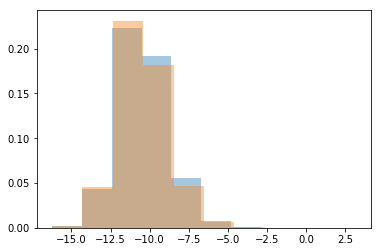

In [36]:
plt.hist(np.log10(box['H_number_density'].flat),alpha=0.4,normed=True)
plt.hist(np.log10(rb['H_number_density']),alpha=0.4,normed=True)
plt.show()

In [75]:
hden = box['H_nuclei_density'][:,200,200]
temp = box['Temperature'][:,200,200]
xs = box['x'][:,200,200].in_units('kpc')
xmin_box = xs.min()
print xmin_box

23649.5422567 kpc


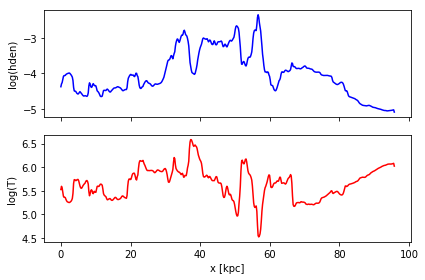

In [91]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(xs-xmin_box,np.log10(hden),'b')
ax[0].set_ylabel('log(hden)')
ax[1].set_ylabel('log(T)')
#ax[0].set_xlabel('x [kpc]')
ax[1].set_xlabel('x [kpc]')
ax[1].plot(xs-xmin_box,np.log10(temp),'r')
plt.tight_layout()
plt.show()

In [83]:
xmin = float((xs.min().in_units('code_length')).value)
xmax = float((xs.max().in_units('code_length')).value)
y = float((box['y'][200,200,200].in_units('code_length')).value)
z = float((box['z'][200,200,200].in_units('code_length')).value)

ray_start = [xmin,y,z]
ray_end = [xmax,y,z]

ray_test = ds.ray(ray_start,ray_end)

In [93]:
xmin_ray = ray_test['x'].min().in_units('kpc')
print xmin_ray

hden_ray = ray_test['H_nuclei_density']
temp_ray = ray_test['Temperature']
xs_ray = ray_test['x'].in_units('kpc')
idx = np.argsort(xs_ray)


23649.5703545 kpc


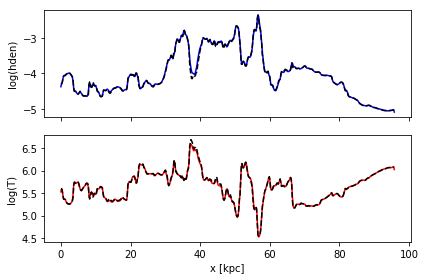

In [103]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(xs-xmin_box,np.log10(hden),'b')
ax[0].plot(xs_ray[idx]-xmin_box,np.log10(hden_ray[idx]),'k--')
ax[0].set_ylabel('log(hden)')
ax[1].set_ylabel('log(T)')
#ax[0].set_xlabel('x [kpc]')
ax[1].set_xlabel('x [kpc]')
ax[1].plot(xs-xmin_box,np.log10(temp),'r')
ax[1].plot(xs_ray[idx]-xmin_box,np.log10(temp_ray[idx]),'k--')
plt.tight_layout()
plt.show()

So there are some differences but not very many when you sample the box with the same resolution as what's native to the must refine region. 